# importing libraries

In [1]:
timm_path = "../input/timm-pytorch-image-models/pytorch-image-models-master"
import sys
sys.path.append(timm_path)
import timm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
from tqdm.notebook import tqdm

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
train  =  pd.read_csv("../input/vinbigdata-chest-xray-abnormalities-detection/train.csv") 
is_normal_df = train.groupby("image_id")["class_id"].agg(lambda s: (s == 14).sum()).reset_index().rename({"class_id": "num_normal_annotations"}, axis=1)
is_normal_df.head()

,image_id,num_normal_annotations
0,000434271f63a053c4128a0ba6352c7f,3
1,00053190460d56c53cc3e57321387478,3
2,0005e8e3701dfb1dd93d53e2ff537b6e,0
3,0006e0a85696f6bb578e84fafa9a5607,3
4,0007d316f756b3fa0baea2ff514ce945,0


To understand this piece of code above go to the awesome notebook of @corochann https://www.kaggle.com/corochann/vinbigdata-2-class-classifier-complete-pipeline/notebook, this peice of code was taken from his notebook.

In [4]:
def change(x):
    if (x==3):
        x=1
    return x
is_normal_df['target'] = is_normal_df['num_normal_annotations'].apply(lambda x: change(x))
df = is_normal_df[["image_id","target"]]
df.head()

,image_id,target
0,000434271f63a053c4128a0ba6352c7f,1
1,00053190460d56c53cc3e57321387478,1
2,0005e8e3701dfb1dd93d53e2ff537b6e,0
3,0006e0a85696f6bb578e84fafa9a5607,1
4,0007d316f756b3fa0baea2ff514ce945,0


# splitting

In [5]:
from sklearn.model_selection import StratifiedKFold
skf  =  StratifiedKFold(n_splits = 5, random_state = 42,shuffle = True)
folds = df.copy()
for f,(tr_idx,val_idx) in enumerate(skf.split(folds,folds.target)):
    folds.loc[val_idx,'fold'] = int(f)
folds['fold'] = folds['fold'].astype(int)    



In [6]:
folds.image_id=folds.image_id+".png"
img_path = "../input/vinbigdata-chest-xray-resized-png-1024x1024/train"
df_paths = [os.path.join(img_path,x) for x in folds.image_id]
folds['path'] = df_paths
folds.head()

,image_id,target,fold,path
0,000434271f63a053c4128a0ba6352c7f.png,1,0,../input/vinbigdata-chest-xray-resized-png-102...
1,00053190460d56c53cc3e57321387478.png,1,3,../input/vinbigdata-chest-xray-resized-png-102...
2,0005e8e3701dfb1dd93d53e2ff537b6e.png,0,0,../input/vinbigdata-chest-xray-resized-png-102...
3,0006e0a85696f6bb578e84fafa9a5607.png,1,3,../input/vinbigdata-chest-xray-resized-png-102...
4,0007d316f756b3fa0baea2ff514ce945.png,0,1,../input/vinbigdata-chest-xray-resized-png-102...


# Transforms

In [7]:
train_aug = A.Compose(
    [  

        A.Resize(300,300,p=1.0),
        A.CLAHE(clip_limit=4.0, p=0.85),

        A.Normalize(
            p=1.0),
        A.RandomCrop(width=250, height=250),
        A.Rotate(limit=40, p=0.9),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25),
        A.OneOf(
                [
                 A.Blur(blur_limit=3, p=0.5),
                 A.ColorJitter(p=0.5)
                ], p=1.0),
        A.Normalize(
            p=1.0),
        ToTensorV2(p=1.0)
    ])

val_aug = A.Compose(
    [
         A.Resize(300,300,p=1.0),
         A.HorizontalFlip(p=0.5),
         A.Normalize(
            p=1.0),
         ToTensorV2(p=1.0)
    ]
)

In [8]:
class Xray(Dataset):
    def __init__(self,df,augs=None):
        self.df = df
        self.augs = augs
    def __len__(self):
        return(len(self.df))
    def __getitem__(self,idx):
        img_src = self.df.loc[idx,'path']
        image = cv2.imread(img_src)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
        
        target = self.df.loc[idx,'target']
        
        if (self.augs):
            transformed = self.augs(image=image)
            image = transformed['image']
        
        return image,torch.tensor(target) 


In [9]:
data = Xray(folds,augs = train_aug)
load = DataLoader(data,batch_size = 1)
img,target = next(iter(load))

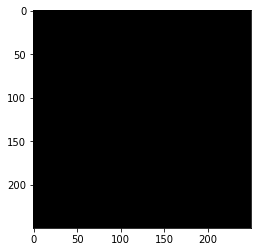

In [10]:
plt.imshow(img.squeeze(0).permute(1,2,0))

# Efficientnet b3 noisy student Model

In [11]:
model1=timm.create_model('resnext50d_32x4d', pretrained=True) # set pretrained=True to use the pretrained weights
num_features = model1.fc.in_features
model1.fc = nn.Linear(num_features, 1)
model1

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnext50d_32x4d-103e99f8.pth" to /root/.cache/torch/hub/checkpoints/resnext50d_32x4d-103e99f8.pth


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): 

In [12]:
model2=timm.create_model('resnext101_32x4d', pretrained=True) # set pretrained=True to use the pretrained weights
num_features = model2.fc.in_features
model2.fc = nn.Linear(num_features, 1)
model2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act3): ReLU(inplace=True)
      (do

In [13]:
model3=timm.create_model('inception_resnet_v2', pretrained=True) # set pretrained=True to use the pretrained weights
num_features = model3.classif.in_features
model3.classif = nn.Linear(num_features, 1)
model3

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/inception_resnet_v2-940b1cd6.pth" to /root/.cache/torch/hub/checkpoints/inception_resnet_v2-940b1cd6.pth


InceptionResnetV2(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [14]:
model4=timm.create_model('resnet18', pretrained=True) # set pretrained=True to use the pretrained weights
num_features = model4.fc.in_features
model4.fc = nn.Linear(num_features, 1)
model4

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
ss=F.sigmoid(model1(torch.randn(3,3,300,300)))
ss

tensor([[0.5248],
        [0.5211],
        [0.5308]], grad_fn=<SigmoidBackward>)

In [16]:
ss=F.sigmoid(model2(torch.randn(3,3,300,300)))
ss

tensor([[0.4498],
        [0.4484],
        [0.4337]], grad_fn=<SigmoidBackward>)

In [17]:
ss=F.sigmoid(model3(torch.randn(3,3,300,300)))
ss

tensor([[0.4820],
        [0.5059],
        [0.4949]], grad_fn=<SigmoidBackward>)

# Helping Functions

In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [19]:
def train_one_epoch(train_loader,model,optimizer,criterion,e,epochs):
    losses = AverageMeter()
    scores = AverageMeter()
    model.train()
    global_step = 0
    loop = tqdm(enumerate(train_loader),total = len(train_loader))
    
    for step,(image,labels) in loop:
        image = image.to(device)
        labels = labels.unsqueeze(1)
        labels= labels.to(device)
        output = model(image)
        batch_size = labels.size(0)
        loss = criterion(output,labels.float())
        
        out = F.sigmoid(output)
        outputs = out.cpu().detach().numpy()
        targets = labels.cpu().detach().numpy()
        try:
            auc = sklearn.metrics.roc_auc_score(targets, outputs)
            losses.update(loss.item(), batch_size)
            scores.update(auc.item(), batch_size)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        
            loop.set_description(f"Epoch {e+1}/{epochs}")
            loop.set_postfix(loss = loss.item(), auc = auc.item(), stage = 'train')
        
            
        except ValueError:
            pass
        
        
       
        
    return losses.avg,scores.avg

In [20]:
def val_one_epoch(loader,model,optimizer,criterion):
    losses = AverageMeter()
    scores = AverageMeter()
    model.eval()
    global_step = 0
    loop = tqdm(enumerate(loader),total = len(loader))
    
    for step,(image,labels) in loop:
        image = image.to(device)
        labels = labels.unsqueeze(1)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            output = model(image)
        loss = criterion(output,labels.float())
        
        out = F.sigmoid(output)
        outputs = out.cpu().detach().numpy()
        targets = labels.cpu().detach().numpy()
        try:
            auc = sklearn.metrics.roc_auc_score(targets, outputs)
            losses.update(loss.item(), batch_size)
            scores.update(auc.item(), batch_size)
            loop.set_postfix(loss = loss.item(), auc = auc.item(), stage = 'valid')
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        except ValueError:
            pass
        
        
        
        
        
    
        
    return losses.avg,scores.avg

# Training loop

In [21]:
def fit(model,fold_n,training_batch_size=8,validation_batch_size=64):
    
    train_data=folds[folds.fold != fold_n]
    val_data=folds[folds.fold == fold_n]
    train_data= Xray(train_data.reset_index(drop=True),augs = train_aug)
    val_data= Xray(val_data.reset_index(drop=True),augs = val_aug)
    
    
    train_loader = DataLoader(train_data,
                             shuffle=True,
                        num_workers=0,
                        batch_size=training_batch_size)
    valid_loader = DataLoader(val_data,
                             shuffle=False,
                        num_workers=0,
                        batch_size=validation_batch_size) 
    model = model
    model.to(device)
    criterion=nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 3,verbose = True)
    epochs= 1
    
    best_acc = 0
    loop = range(epochs)
    for e in loop:
        
        train_loss,train_auc = train_one_epoch(train_loader,model,optimizer,criterion,e,epochs) 
         

In [22]:
fit(model1,0)

  0%|          | 0/1500 [00:00<?, ?it/s]

In [23]:
fit(model2,0)

  0%|          | 0/1500 [00:00<?, ?it/s]

In [24]:
fit(model3,0)

  0%|          | 0/1500 [00:00<?, ?it/s]

In [25]:
fit(model4,0)

  0%|          | 0/1500 [00:00<?, ?it/s]

Not training further epochs due to GPU constraints
#To get a idea of this full pipeline, head over to https://www.kaggle.com/mrinath/another-simple-and-fast-pytorch-pipeline
#say_my_name

# Prediction:

In [26]:
# test_meta = pd.read_csv('../input/vinbigdata-testmeta/test_meta.csv')

# folds_test = test_meta.copy()
# folds_test.image_id=folds.image_id+".png"
# img_path = "../input/vinbigdata-chest-xray-resized-png-1024x1024/train"
# df_paths = [os.path.join(img_path,x) for x in folds.image_id]
# folds['path'] = df_paths
# folds.head()

# #dataset_dicts_test = get_vinbigdata_dicts_test(imgdir, test_meta, debug=debug)
# test_dataset = Xray(test_data.reset_index(drop=True),augs = test_aug)
# test_loader = DataLoader(
#     test_dataset,
#     batch_size=flags.valid_batchsize,
#     num_workers=flags.num_workers,
#     shuffle=False,
#     pin_memory=True,
# )
# test_pred = classifier.predict_proba(test_loader).cpu().numpy()
# test_pred_df = pd.DataFrame({
#     "image_id": [d["image_id"] for d in dataset_dicts_test],
#     "class0": test_pred[:, 0],
#     "class1": test_pred[:, 1]
# })
# test_pred_df.to_csv(outdir/"test_pred.csv", index=False)

In [27]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt



In [28]:
test_df = pd.read_csv('../input/vinbigdata-chest-xray-abnormalities-detection/sample_submission.csv')
test_df.shape

(3000, 2)

In [29]:
class VinBigTestDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        records = self.df[(self.df['image_id'] == image_id)]
        records = records.reset_index(drop=True)

        dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")
        
        image = dicom.pixel_array
        
        intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
        slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
            
        image += np.int16(intercept)        
        
        image = np.stack([image, image, image])
        image = image.astype('float32')
        image = image - image.min()
        image = image / image.max()
        image = image * 255.0
        image = image.transpose(1,2,0)
       
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

In [30]:
def get_test_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ])

In [31]:
#get number of input features for the classifier
#in_features = model1.roi_heads.box_predictor.cls_score.in_features

In [32]:
#model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [33]:
DIR_TEST = '../input/vinbigdata-chest-xray-abnormalities-detection/test'

In [34]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = VinBigTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [35]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))

    return " ".join(pred_strings)

In [36]:
detection_threshold = 0.5
results1 = []
for images, image_ids in test_data_loader:
    images = torch.Tensor(list(image.to(device) for image in images))
    outputs = model1(images)

for i, image in enumerate(images):
    image_id = image_ids[i]

    result1 = {
        'image_id': image_id,
        'PredictionString': '14 1.0 0 0 1 1'
        }
    boxes = outputs[i]['boxes'].data.cpu().numpy()
    labels = outputs[i]['labels'].data.cpu().numpy()
    scores = outputs[i]['scores'].data.cpu().numpy()
    if len(boxes) > 0:

        labels = labels - 1
        labels[labels == -1] = 14
        selected = scores >= detection_threshold
        boxes = boxes[selected].astype(np.int32)
        scores = scores[selected]
        labels = labels[selected]
    if len(boxes) > 0:
        result1 = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(labels, boxes, scores)
        }
    results1.append(result)

ValueError: only one element tensors can be converted to Python scalars

In [37]:
detection_threshold = 0.5
results2 = [] 
with torch.no_grad():
    for images, image_ids in test_data_loader:

        images = list(image.to(device) for image in images)
        outputs = model2(images)

        for i, image in enumerate(images):
            image_id = image_ids[i]

            result2 = {
                'image_id': image_id,
                'PredictionString': '14 1.0 0 0 1 1'
            }
            boxes = outputs[i]['boxes'].data.cpu().numpy()
            labels = outputs[i]['labels'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()
            if len(boxes) > 0:

                labels = labels - 1
                labels[labels == -1] = 14
                selected = scores >= detection_threshold
                boxes = boxes[selected].astype(np.int32)
                scores = scores[selected]
                labels = labels[selected]
                if len(boxes) > 0:
                    result2 = {
                        'image_id': image_id,
                        'PredictionString': format_prediction_string(labels, boxes, scores)
                    }
            results2.append(result)     

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not list

In [38]:
detection_threshold = 0.5
results3 = []
with torch.no_grad():
    for images, image_ids in test_data_loader:

        images = list(image.to(device) for image in images)
        outputs = model3(images)

        for i, image in enumerate(images):
            image_id = image_ids[i]

            result3 = {
                'image_id': image_id,
                'PredictionString': '14 1.0 0 0 1 1'
            }
            boxes = outputs[i]['boxes'].data.cpu().numpy()
            labels = outputs[i]['labels'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()
            if len(boxes) > 0:

                labels = labels - 1
                labels[labels == -1] = 14
                selected = scores >= detection_threshold
                boxes = boxes[selected].astype(np.int32)
                scores = scores[selected]
                labels = labels[selected]
                if len(boxes) > 0:
                    result3 = {
                        'image_id': image_id,
                        'PredictionString': format_prediction_string(labels, boxes, scores)
                    }
            results3.append(result)     

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not list

In [39]:
detection_threshold = 0.5
results4 = []
with torch.no_grad():
    for images, image_ids in test_data_loader:

        images = list(image.to(device) for image in images)
        outputs = model4(images)

        for i, image in enumerate(images):
            image_id = image_ids[i]

            result4 = {
                'image_id': image_id,
                'PredictionString': '14 1.0 0 0 1 1'
            }
            boxes = outputs[i]['boxes'].data.cpu().numpy()
            labels = outputs[i]['labels'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()
            if len(boxes) > 0:

                labels = labels - 1
                labels[labels == -1] = 14
                selected = scores >= detection_threshold
                boxes = boxes[selected].astype(np.int32)
                scores = scores[selected]
                labels = labels[selected]
                if len(boxes) > 0:
                    result4 = {
                        'image_id': image_id,
                        'PredictionString': format_prediction_string(labels, boxes, scores)
                    }
            results4.append(result)     

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not list

In [40]:
pred = 0.25*result1 + 0.25*result2 + 0.25*result3 + 0.25*result4

NameError: name 'result1' is not defined

In [41]:
test_df = pd.DataFrame(pred, columns=['image_id', 'PredictionString'])
test_df.head()

NameError: name 'pred' is not defined

In [42]:
test_df.to_csv('submission.csv', index=False)